In [1]:
import os
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
from src import render_model_gym
from datetime import datetime
import importlib
from src import render_model_gym

from src import helpers
from src.definitions import PROJECT_ROOT, enforce_absolute_path

import src.lucy_classes_v1 as lucy

importlib.reload(lucy)

<module 'src.lucy_classes_v1' from 'c:\\GitHub\\training-lucy\\src\\lucy_classes_v1.py'>

In [3]:
# Configuration
n_envs = 7
xml_path = enforce_absolute_path("animals/lucy_v2.xml")


def new_vec_env(env:lucy.LucyEnv, monitor_dir:str):
    return make_vec_env(
    env,
    n_envs=n_envs,
    vec_env_cls=SubprocVecEnv,
    monitor_dir=monitor_dir,
)


print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(
    f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators"
)
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

sim_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/lucy_v1_standing_{sim_start_time}/"
os.makedirs(log_dir, exist_ok=True)
print(f"Standing log directory: {log_dir}")




MuJoCo version: 3.4.0
Lucy model loaded: 59 qpos dims, 47 qvel dims, 41 actuators
Observation space will be: 104 dims (qpos[2:] + qvel)
Standing log directory: logs/lucy_v1_standing_2026-01-10_15-15/


Episode terminated during frame collection.


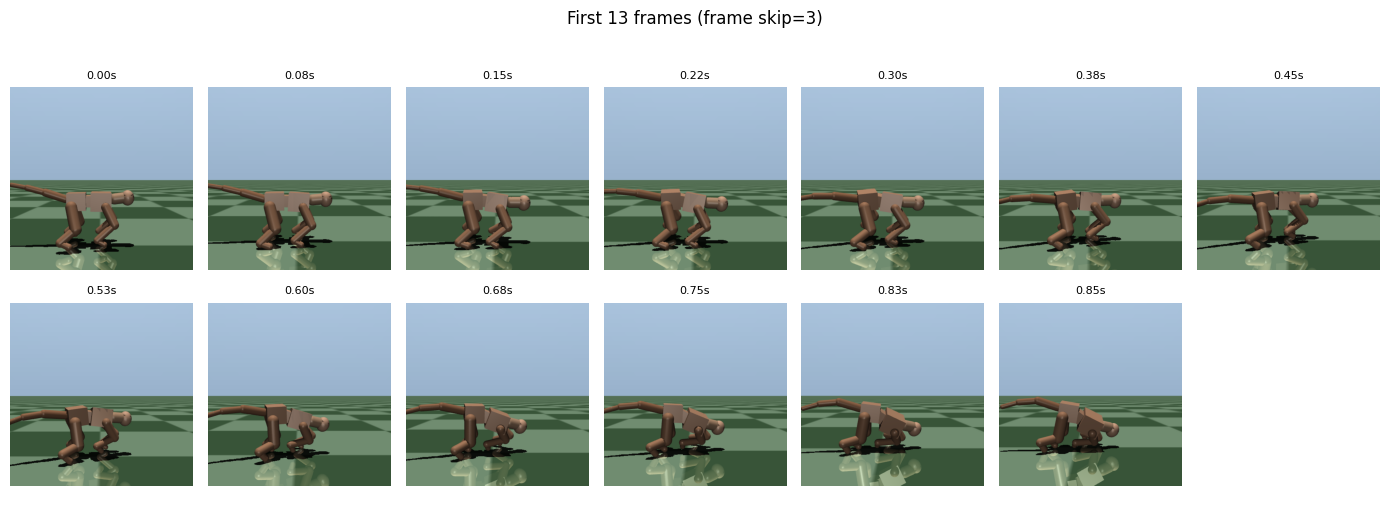

,time,chest_height,forward_velocity,total_height_reward,head_direction_reward,leg_pos_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.179504,0.046898,1.109264,0.096487,0.213017,2.930459,9.710015
2,0.150,0.178160,0.026717,0.658744,0.092431,0.207475,2.496984,17.172880
3,0.225,0.177587,-0.135092,0.589559,0.098708,0.203138,2.452969,24.804770
4,0.300,0.178176,-0.053456,0.661348,0.089260,0.197224,2.481304,32.089202
5,0.375,0.176026,0.022001,0.518798,0.071092,0.189252,2.283024,39.160551
6,0.450,0.174144,-0.029685,0.102939,0.063875,0.182052,1.921082,45.396873
7,0.525,0.172560,0.128028,0.500587,0.063180,0.176542,2.236132,52.245928
8,0.600,0.159470,0.101857,0.500000,0.062322,0.168296,2.203549,58.884749
9,0.675,0.147473,0.146900,0.500000,0.053552,0.160669,2.208645,65.471549


In [4]:
importlib.reload(lucy)


def make_env(render_mode="None", *args, **kwargs):
    return lucy.LucyStandingWrapper(
        lucy.LucyEnv(xml_file=xml_path, render_mode=render_mode, max_episode_seconds=10),
    )


env = make_env(render_mode="rgb_array")

df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=[
        "chest_height",
        "forward_velocity",
        "total_height_reward",
        "head_direction_reward",
        "leg_pos_reward"
    ],
)
plt.show()
df

In [5]:
standing_vec_env = new_vec_env(make_env, log_dir)


standing_vec_env = VecMonitor(standing_vec_env, log_dir)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {log_dir}")




standing_model = PPO(
    "MlpPolicy",
    standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=512,
    n_epochs=3,
    gamma=0.99,
    gae_lambda=0.9,
    clip_range=0.2,
    ent_coef=0.01,  # Encourage exploration
    learning_rate=2e-4,
    target_kl=0.02,
    policy_kwargs=dict(
        net_arch=dict(pi=[512, 512], vf=[512, 512])  # Larger network for complex body
    ),
)

# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 800_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Created 7 parallel standing environments
Logging to: logs/lucy_v1_standing_2026-01-10_15-15/
Using cpu device
Training standing policy for 800,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48.2     |
|    ep_rew_mean     | 22.3     |
| time/              |          |
|    fps             | 1638     |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 44.2        |
|    ep_rew_mean          | 25.1        |
| time/                   |             |
|    fps                  | 1579        |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.021637427 |
|    clip_fraction        | 0.328     

In [6]:
standing_model_path = os.path.join(
    PROJECT_ROOT, "trained_models", f"lucy_v2_standing_model_{sim_start_time}"
)
standing_model.save(standing_model_path)
print(f"Standing model saved to: {standing_model_path}")

Standing model saved to: C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-10_15-15


In [13]:
importlib.reload(render_model_gym)
render_model_gym.render_model_gym(standing_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0250s per step
Running simulation at 1.0x speed... Close the window to exit.


c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)



Stopped by user


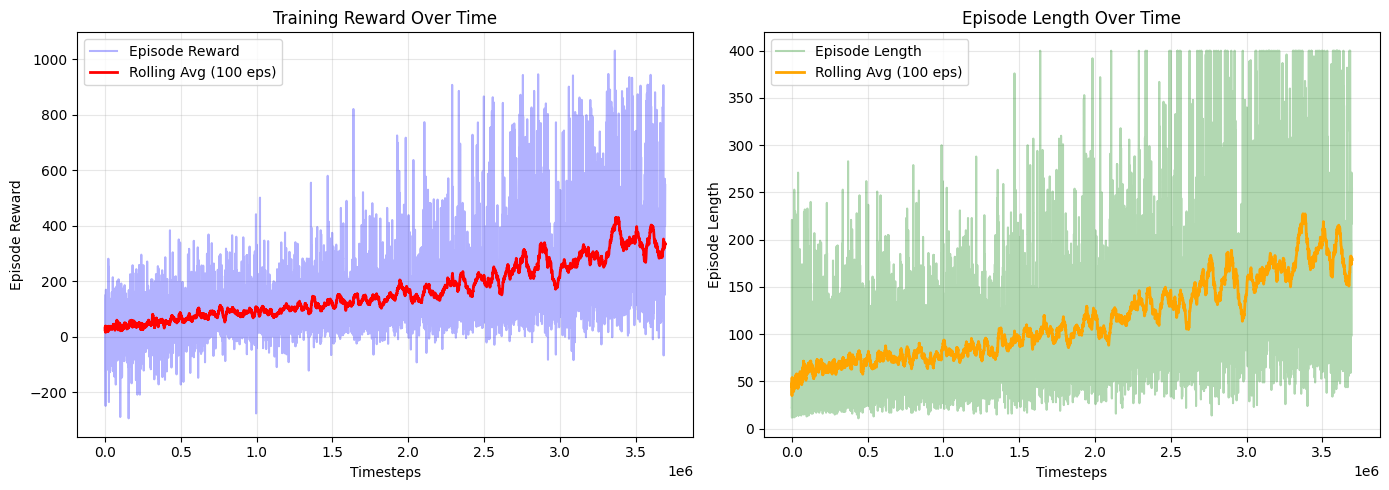

Training Summary:
Total episodes: 17920
Final avg reward (last 100 eps): 334.87
Max reward: 1030.95
  Final avg length (last 100 eps): 178.9


In [7]:
standing_df = load_results(log_dir)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\326po\AppData\Local\Temp\ipykernel_21468\4053533647.py:2: SyntaxWarning: invalid escape sequence '\G'
  standing_model_path = "C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_11-03"


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


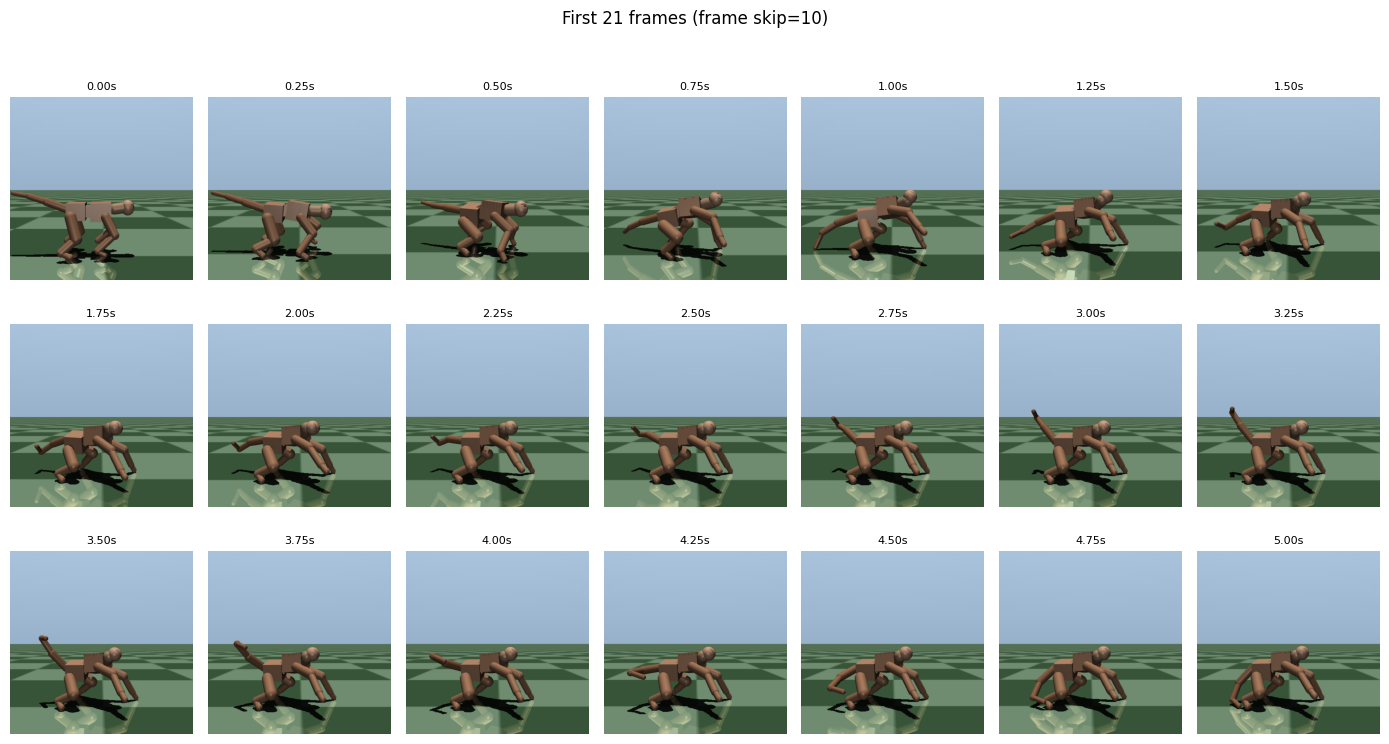

,time,chest_height,forward_velocity,height_reward,head_direction_reward,reward,cum_reward
0,0.00,NaN,NaN,None,NaN,NaN,NaN
1,0.25,0.188273,0.083325,None,0.066318,3.287940,33.537243
2,0.50,0.184114,-0.198091,None,0.020985,2.758347,60.267016
3,0.75,0.199726,0.004032,None,0.036378,2.712676,87.523470
4,1.00,0.187315,-0.077847,None,0.080122,0.688793,106.534850
5,1.25,0.175565,0.049447,None,0.098812,1.835825,129.194664
6,1.50,0.176795,-0.047550,None,0.056105,1.824942,147.155329
7,1.75,0.179020,-0.000173,None,0.026155,2.209820,167.123607
8,2.00,0.180283,-0.016312,None,0.024624,2.802201,193.706770
9,2.25,0.179059,-0.005285,None,0.036369,2.207891,218.465286


In [11]:

if "standing_model_path" not in locals():
    standing_model_path = "C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_11-03"

    
model = PPO.load(
    standing_model_path, env=make_env()
)
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=[
        "chest_height",
        "forward_velocity",
        "height_reward",
        "head_direction_reward",
    ],
    model=model,
)
plt.show()
display(df)

# Walking training

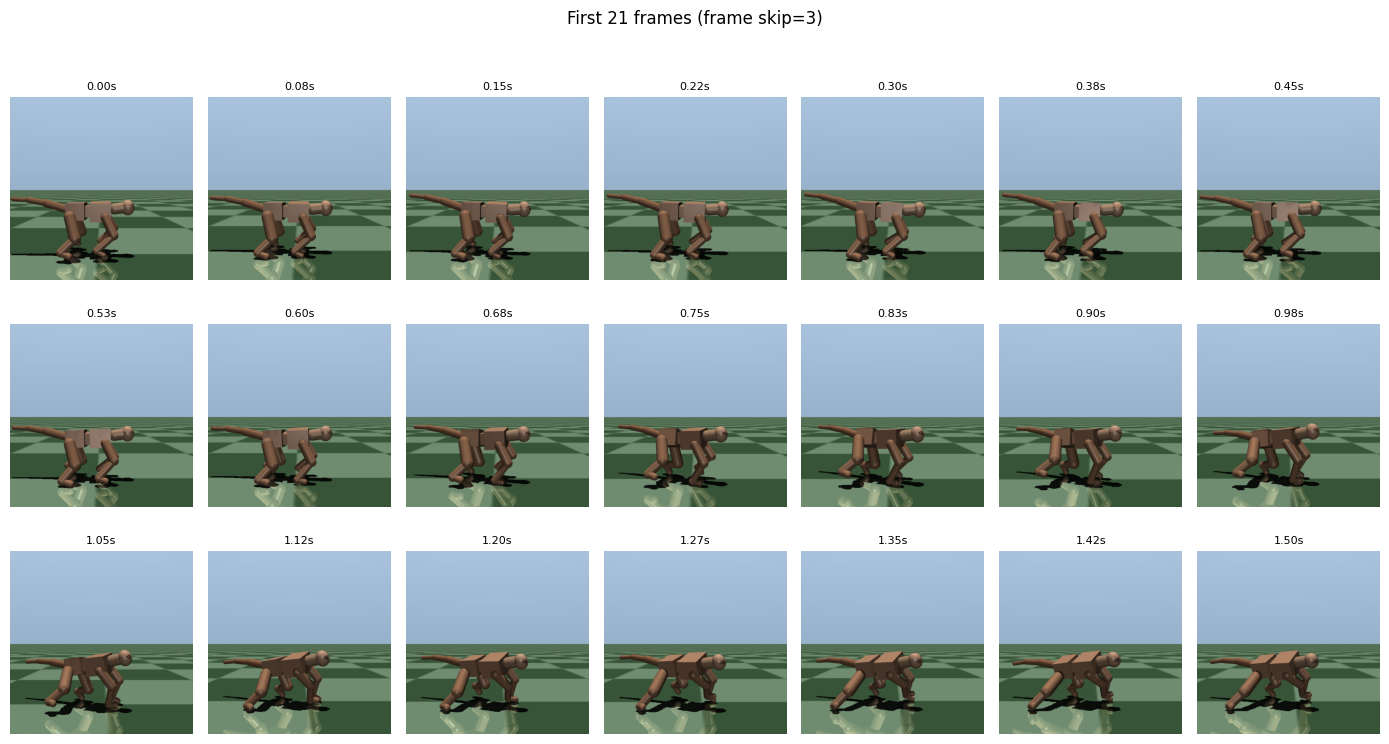

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.183645,0.086169,0.096792,0.0,-0.150655,0.072982,1.500528,4.268245
2,0.150,0.186328,0.027021,0.020017,0.0,-0.380329,0.073684,1.353817,8.464238
3,0.225,0.185382,0.017201,0.007604,0.0,-0.182773,0.073820,1.401468,12.577840
4,0.300,0.182025,0.091524,0.077593,0.0,-0.177545,0.072782,1.472652,16.958955
5,0.375,0.182978,-0.010489,-0.018621,0.0,-0.296955,0.071398,1.339371,21.152658
6,0.450,0.185837,-0.081150,-0.082615,0.0,-0.216998,0.071131,1.299934,25.073637
7,0.525,0.187029,-0.115678,-0.099297,0.0,-0.168105,0.070823,1.298661,28.920512
8,0.600,0.185855,-0.024457,-0.017338,0.0,-0.027597,0.069905,1.420892,33.086855
9,0.675,0.189159,-0.012657,-0.001695,0.0,-0.094427,0.067534,0.809601,35.583778


In [ ]:
# Create walking training environment
importlib.reload(lucy)

walking_attrKeys =[
    "chest_height",
    "forward_velocity",
    "forward_reward",
    "gait_reward",
    "stillness_reward",
    "leg_pos_reward",
    ]


walking_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
walking_log_dir = f"logs/lucy_walking_{walking_start_time}/"
os.makedirs(walking_log_dir, exist_ok=True)


def make_walking_env(render_mode="None"):
    """Factory function for walking environment."""
    env = lucy.LucyEnv(
        xml_file=xml_path,
        render_mode=render_mode,
        max_episode_seconds=30,
    )
    env = lucy.LucyWalkingWrapper(
        env,
        forward_weight=1.0,
        gait_weight=0.2,
        body_contact_penalty=-2.0,
        standing_reward_discount_factor=0.3,
    )
    return env



env = make_walking_env(render_mode="rgb_array")
model = PPO.load(standing_model_path, env=env)
model.set_env(env)




  # attach env so model.predict works
df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=walking_attrKeys,
    model=model,
)
plt.show()
df

In [ ]:
walking_vec_env = new_vec_env(make_walking_env, walking_log_dir)
print(f"Loading from standing model at: {standing_model_path}")



walking_model = PPO(
    "MlpPolicy",
    walking_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=512,
    n_epochs=3,
    gamma=0.99,
    gae_lambda=0.9,
    clip_range=0.2,
    ent_coef=0.01,  # Encourage exploration
    learning_rate=2e-4,
    target_kl=0.02,
    policy_kwargs=dict(
        net_arch=dict(pi=[512, 512], vf=[512, 512])  # Larger network for complex body
    ),
)

walking_model = PPO.load(standing_model_path, env=walking_vec_env)
walking_model.set_env(walking_vec_env)

walking_model.learn(total_timesteps=1_000_000)

Loading from standing model at: C:\GitHub	raining-lucy	rained_models\lucy_v1_standing_model_2026-01-10_11-03
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 48.6     |
| time/              |          |
|    fps             | 1440     |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 44.9        |
|    ep_rew_mean          | 48.7        |
| time/                   |             |
|    fps                  | 1359        |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.016107755 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.

In [ ]:
walking_model_path = os.path.join(
    PROJECT_ROOT, "trained_models", f"lucy_v1_walking_model_{walking_start_time}"
)
walking_model.save(walking_model_path)

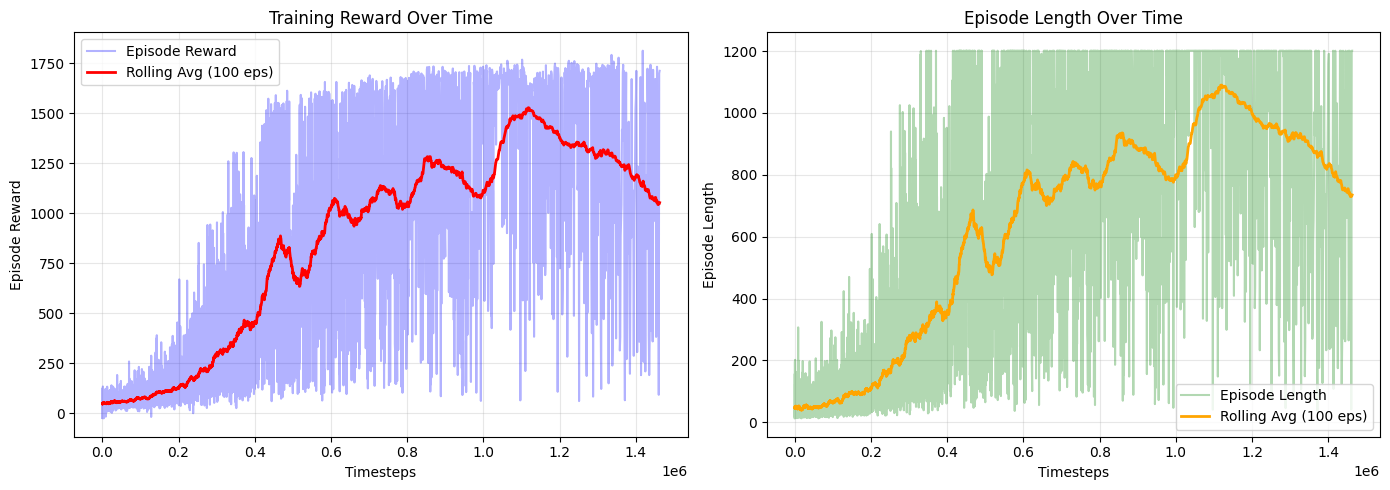

Training Summary:
Total episodes: 5560
Final avg reward (last 100 eps): 1053.53
Max reward: 1813.97
  Final avg length (last 100 eps): 734.9


In [ ]:
walking_df = load_results(walking_log_dir)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


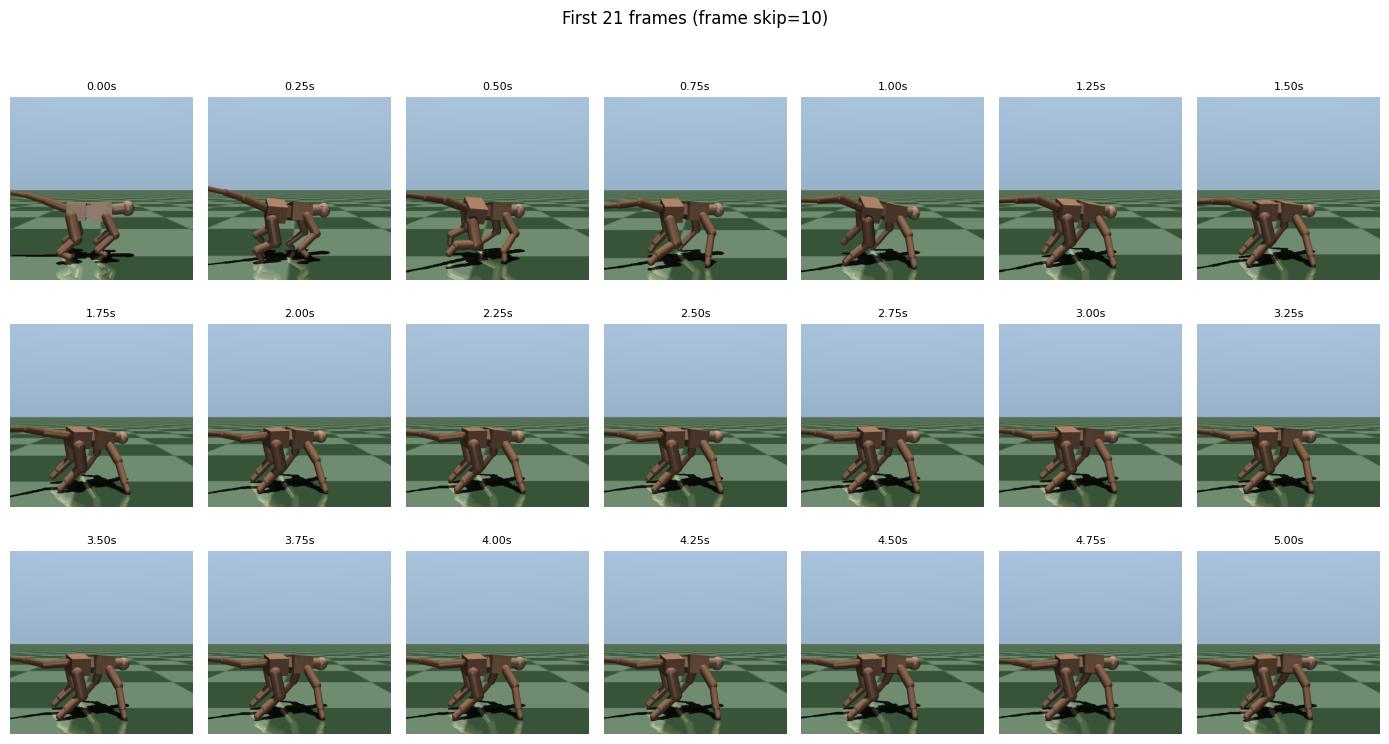

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,reward,cum_reward
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.25,0.196520,0.311947,1.659459,0.0,-0.026510,0.070706,3.087621,21.629986
2,0.50,0.195082,0.051350,0.258007,0.0,-0.249762,0.053247,1.605490,46.240482
3,0.75,0.207020,-0.090643,-0.491288,-0.0,-0.168663,0.054051,0.886765,58.975624
4,1.00,0.202237,0.220616,0.663873,0.0,-0.066860,0.055171,2.064341,74.410502
5,1.25,0.202559,-0.047429,-0.240072,-0.0,-0.283810,0.056497,1.094375,85.894388
6,1.50,0.203626,-0.008979,-0.054006,-0.0,-0.371583,0.056269,1.257815,98.037801
7,1.75,0.205048,-0.001142,-0.006986,-0.0,-0.401915,0.056254,1.293995,111.026208
8,2.00,0.204095,0.003051,0.002130,0.0,-0.367011,0.056507,1.316122,123.800499
9,2.25,0.202436,0.006897,0.016958,0.0,-0.352293,0.056067,1.336909,137.495970


In [ ]:
model = PPO.load(walking_model_path, env=make_walking_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_walking_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=walking_attrKeys+["leg_pos_reward"],
    model=model,
)
plt.show()
display(df)

In [ ]:
render_model_gym.render_model_gym(walking_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0250s per step
Running simulation at 1.0x speed... Close the window to exit.


c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)



Stopped by user
